- GoogLeNet은 22개의 층으로 구성되었으나 VGGNet보다 층수가 많지만 파라미터 수는 1/12에 불과하다.
    - 하지만 훨씬 향상된 성능을 보여준다.
    - 인셉션 모듈이라는 새로운 요소를 도입했다.
    - 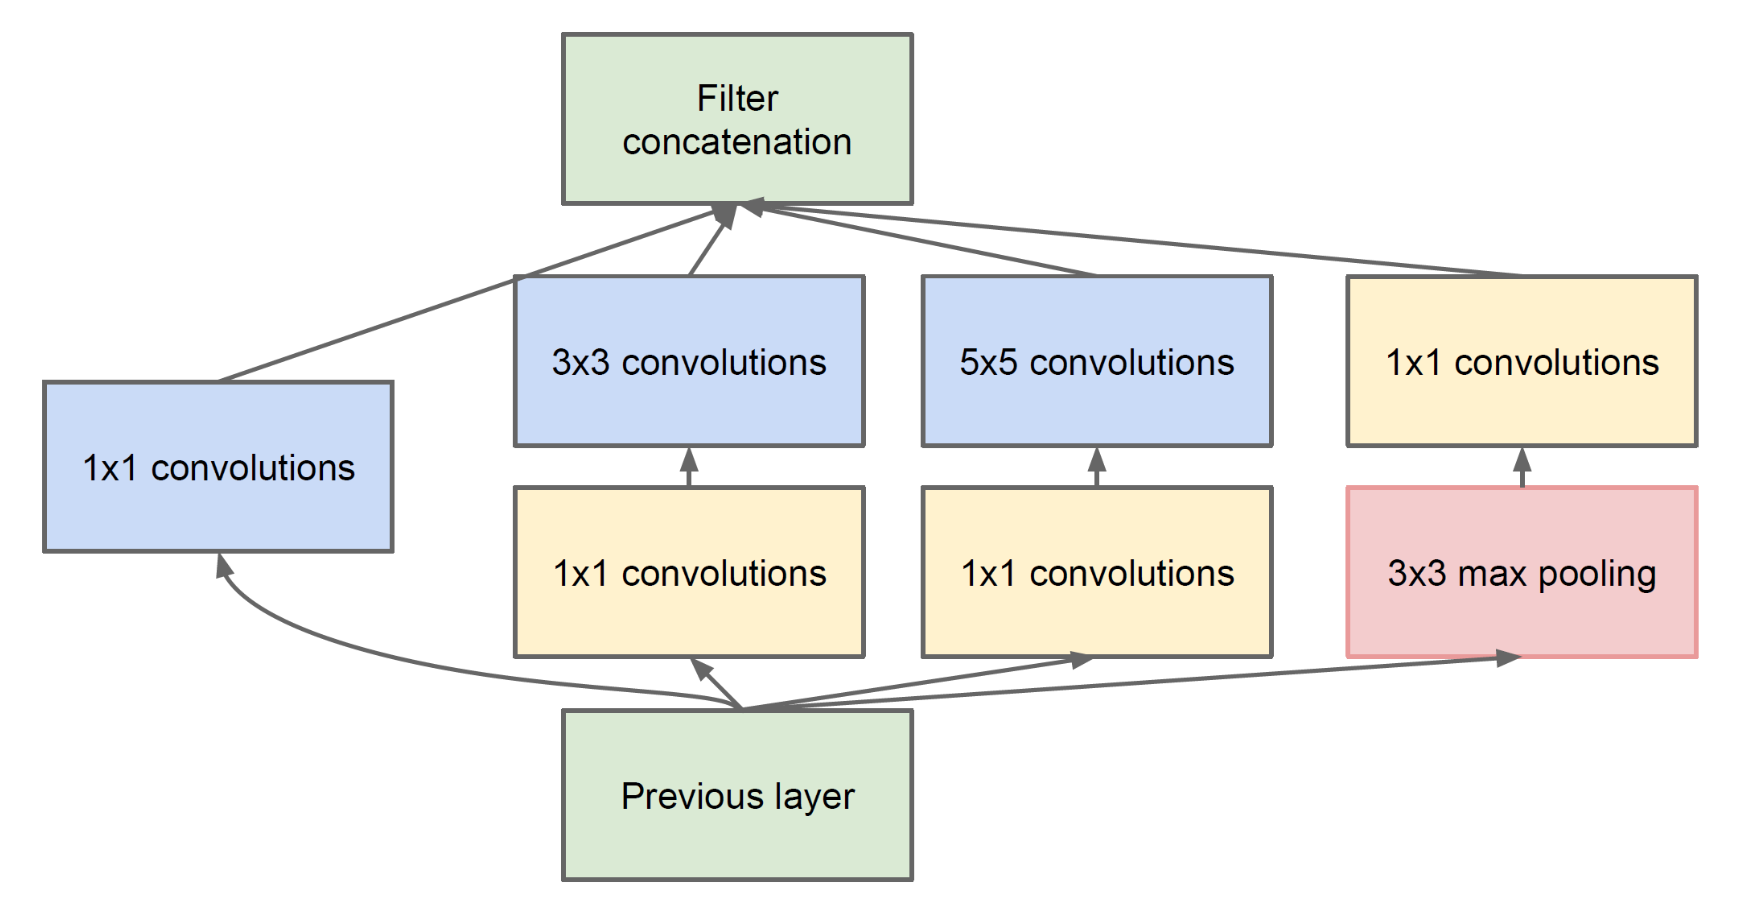
    - 인셉션 모듈이란 합송곱층의 필터 크기나 풀링층의 배치를 직접 결정하는 대신에 블록 전체에 똑같은 설정을 적용하는 것이다.
    - 인셉션 구조에서는 합성곱층과 풀링층으로 인셉션 모듈을 구성한 다음 이 인셉션 모듈과 풀링층을 쌓아 특징 추출기를 구성한다.
      그 뒤에 이어지는 분류기는 기존과 마찬가지로 전결합층으로 구성된다.
    - 층은 더 많지만 파라미터 수가 적은 이유는 ``차원 축소층(1*1 합성곱층 or 병목층)``때문이다.
          - 1*1 합성곱층은 이미지 크기는 유지한 채 출력의 채널 수를 자유로이 변경할 수 있게 된다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

## Inception module

In [19]:
class InceptionModule(nn.Module):
    def __init__(self,in_channels, ch1x1, ch3x3_red, ch3x3, ch5x5_red, ch5x5, pool):
        super(InceptionModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels,ch1x1, kernel_size=1)
        self.conv3x3 = nn.Sequential(
            BaseConv2d(in_channels, ch3x3_red, kernel_size = 1),
            BaseConv2d(ch3x3_red, ch3x3, kernel_size = 3, padding = 1)
        )
        self.conv5x5 = nn.Sequential(
            BaseConv2d(in_channels, ch5x5_red, kernel_size = 1),
            BaseConv2d(ch5x5_red, ch5x5, kernel_size = 5, padding = 2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            BaseConv2d(in_channels, pool, kernel_size = 1)
        )
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)
        return torch.cat([x1, x2, x3, x4], 1)
class BaseConv2d(nn.Module):
    def __init__(self,in_channels, out_channels, **kwargs):
        super(BaseConv2d,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.ReLU = nn.ReLU(inplace = True)
    def forward(self, x):
        return self.ReLU(self.conv(x))

## GoogLeNet

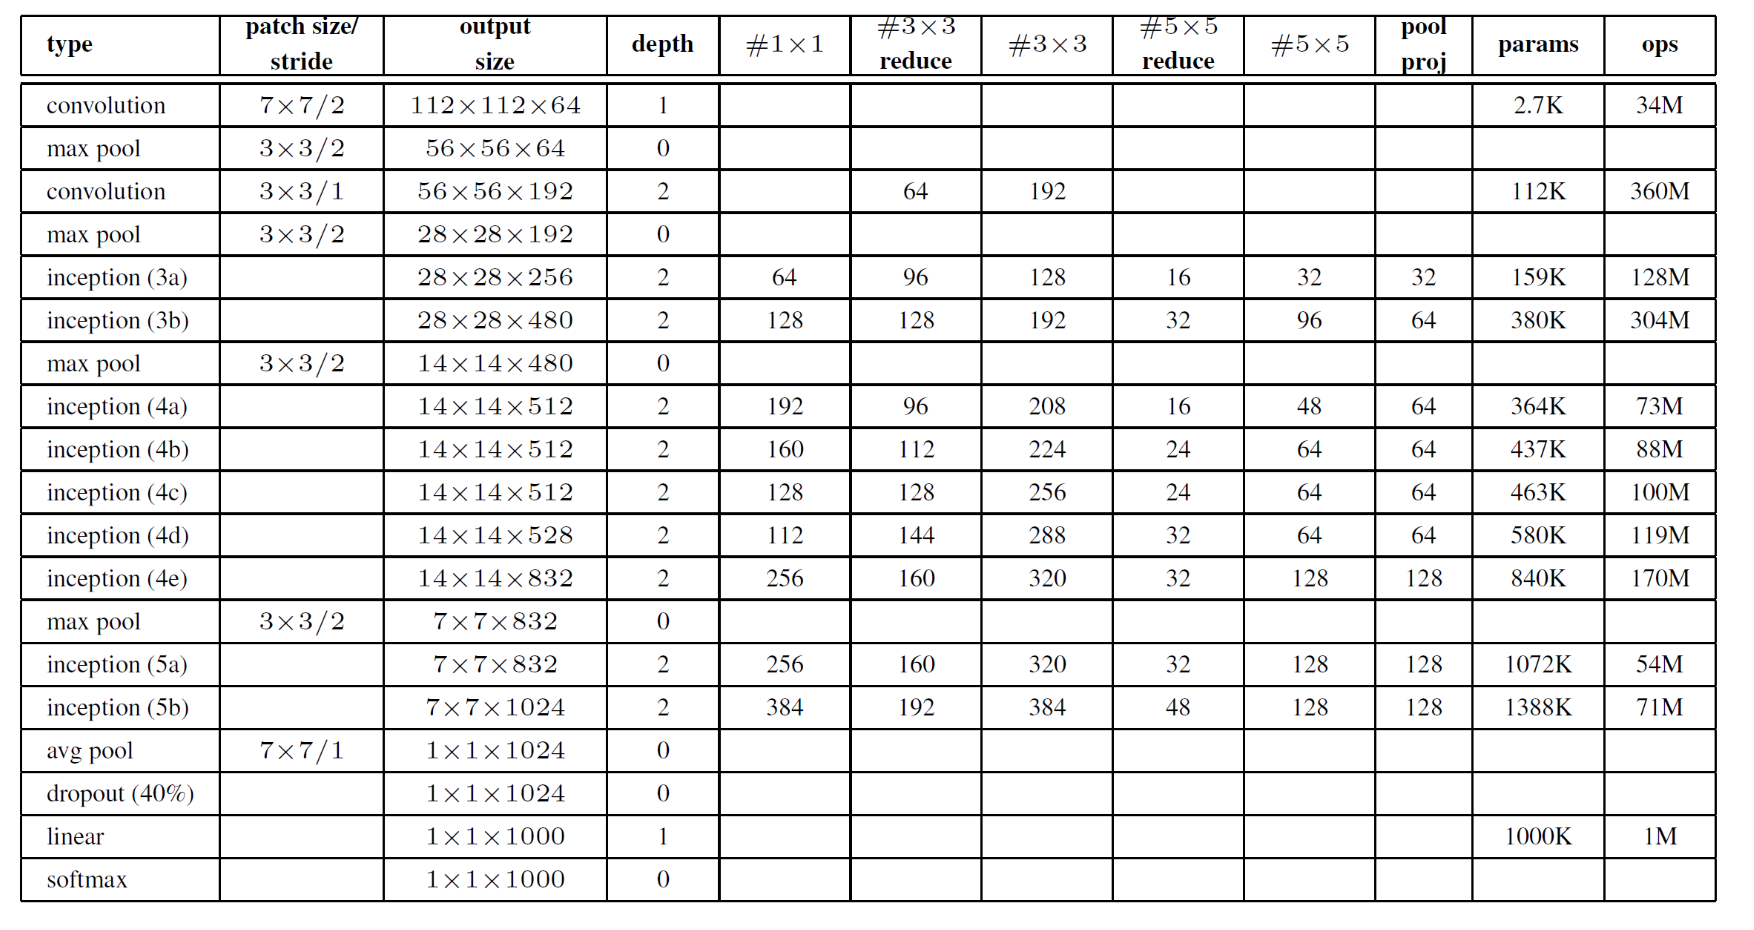

In [23]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(GoogLeNet,self).__init__()
        self.training = True
        # Part A
        self.conv1 = nn.Sequential(
            BaseConv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3), #padding은 어떻게 구하지?
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
            nn.LocalResponseNorm(2)
        )
        self.conv2 = nn.Sequential(
            BaseConv2d(64,64,kernel_size=1),
            BaseConv2d(64,192,kernel_size=3,padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
        )
        # Part B
        self.inception_3a = InceptionModule(192,64,96,128,16,32,32)
        self.inception_3b = InceptionModule(256,128,128,192,32,96,64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        
        self.inception_4a = InceptionModule(480,192,96,208,16,48,64)
        self.aux1 = AuxModule(512, num_classes)

        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxModule(528, num_classes)
        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        # Part C
        # self.avgpool = nn.AvgPool2d(kernel_size= 7, stride= 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024,num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)                
        if self.training:
            return [x, out1, out2]
        else:
            return x
    
    def set_train(self):
        self.training = True
        
    def set_eval(self):
        self.training = False


class AuxModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxModule, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.conv1 = BaseConv2d(in_channels, 128, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

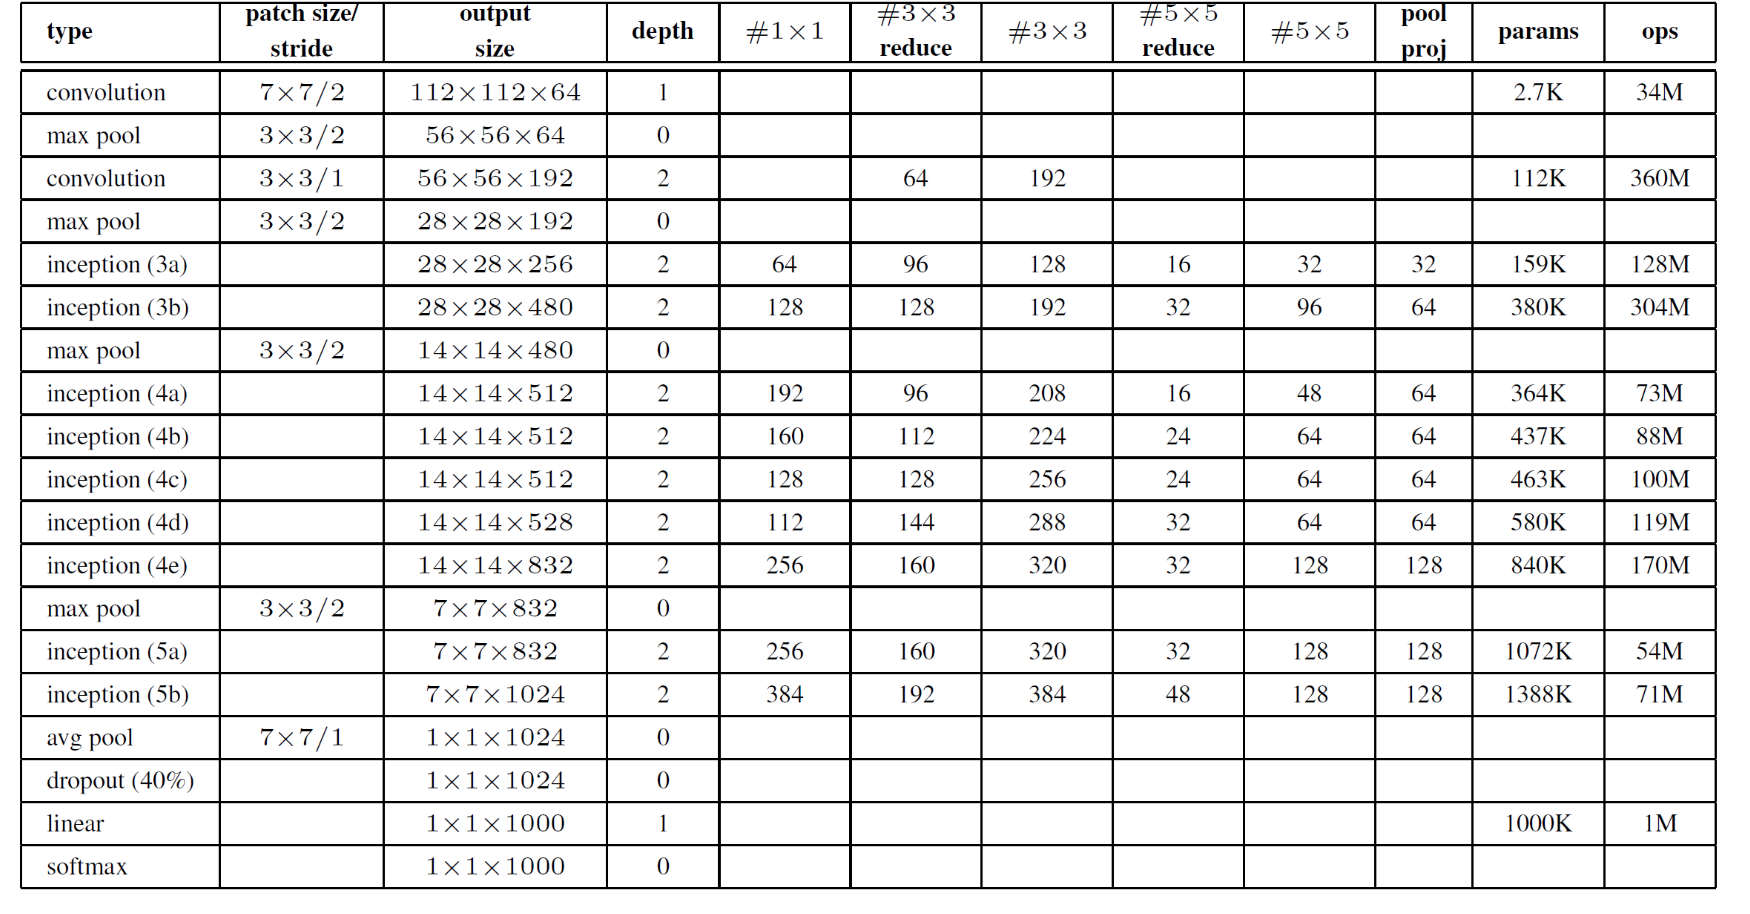

In [24]:
model = GoogLeNet(3,10)

In [25]:
summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
        BaseConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 LocalResponseNorm-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
              ReLU-7           [-1, 64, 56, 56]               0
        BaseConv2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         110,784
             ReLU-10          [-1, 192, 56, 56]               0
       BaseConv2d-11          [-1, 192, 56, 56]               0
LocalResponseNorm-12          [-1, 192, 56, 56]               0
        MaxPool2d-13          [-1, 192, 28, 28]               0
           Conv2d-14           [-1, 64,

/Users/goodyoung/Desktop/GIt/myMLstudy/.mlvenv/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
